# Hourly Time Series Forecasting using XGBoost

[If you haven't already first check out my previous notebook forecasting on the same data using Prophet](https://www.kaggle.com/robikscube/hourly-time-series-forecasting-with-prophet)

In this notebook we will walk through time series forecasting using XGBoost. The data we will be using is hourly energy consumption.

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

In [6]:
pjme = pd.read_csv('./input/PJME_hourly.csv', index_col=[0], parse_dates=[0])

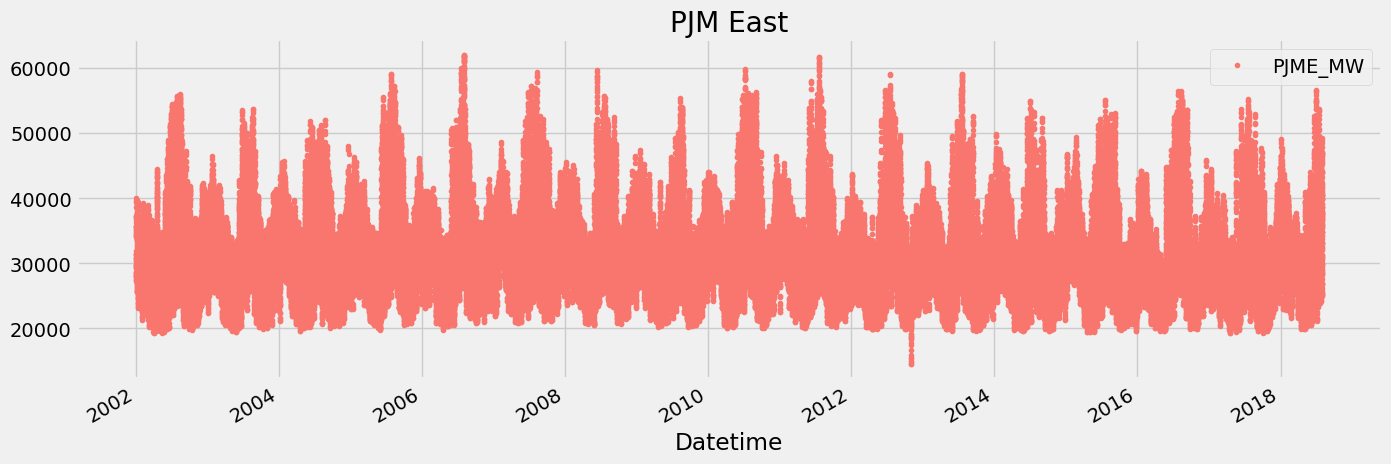

In [7]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [8]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

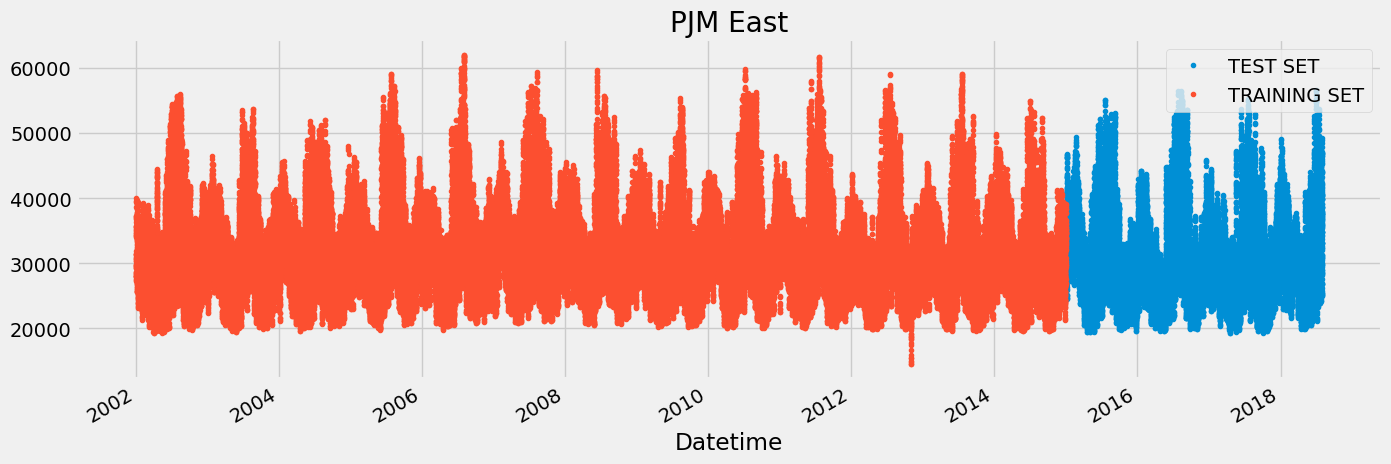

In [9]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

# Create Time Series Features

In [10]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    # df['weekofyear'] = df['date'].dt.weekofyear # deprecated
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth',]] #'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [11]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

# Create XGBoost Model

In [12]:
reg = xgb.XGBRegressor(n_estimators=1000, device = "cuda")
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

c:\Apps\anaconda3\envs\ML6102project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

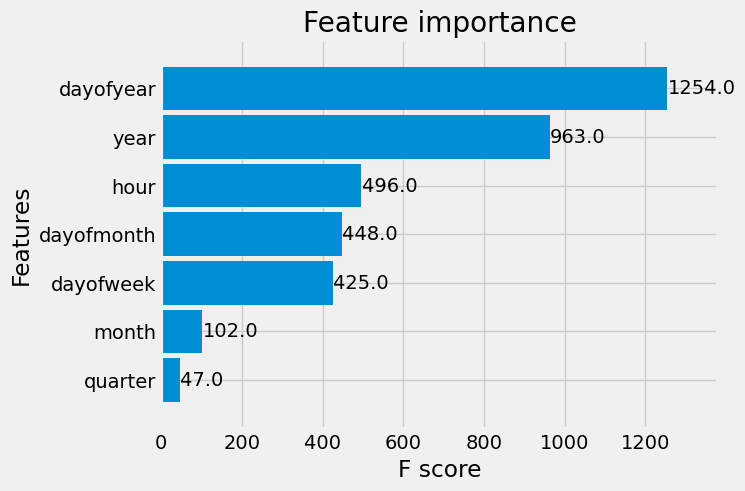

In [13]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [14]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

c:\Apps\anaconda3\envs\ML6102project\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:12:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


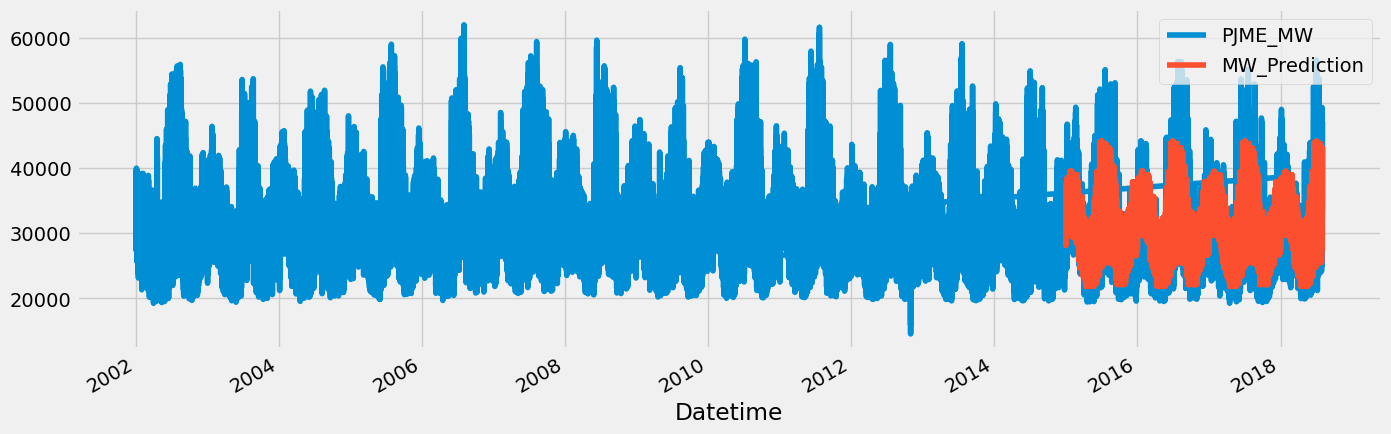

In [15]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

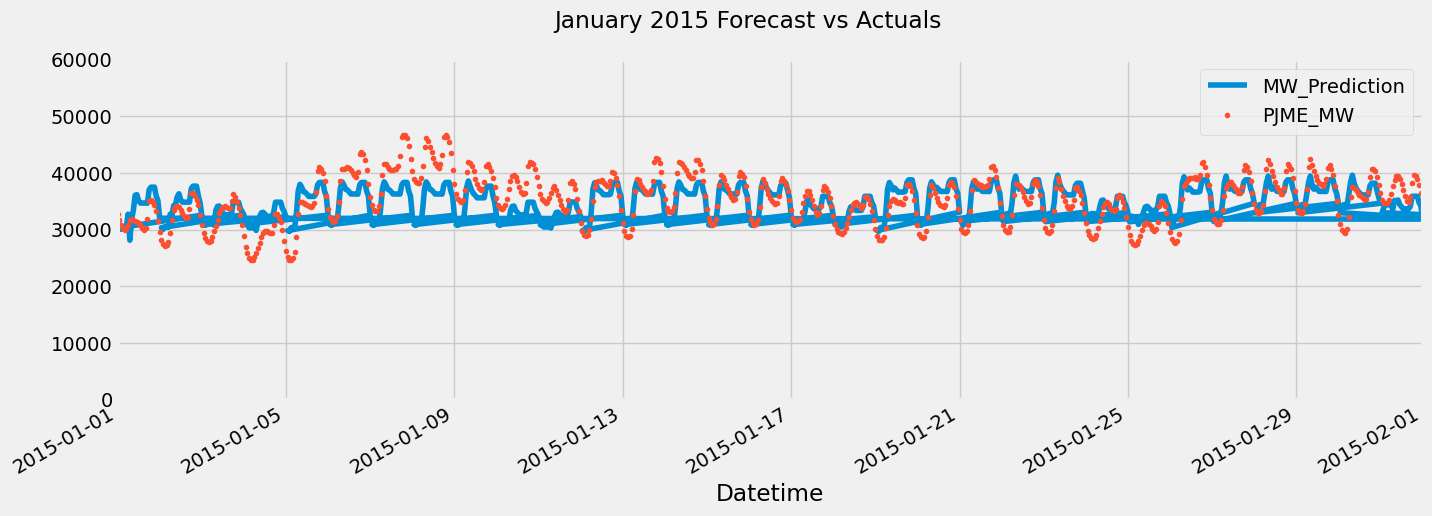

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

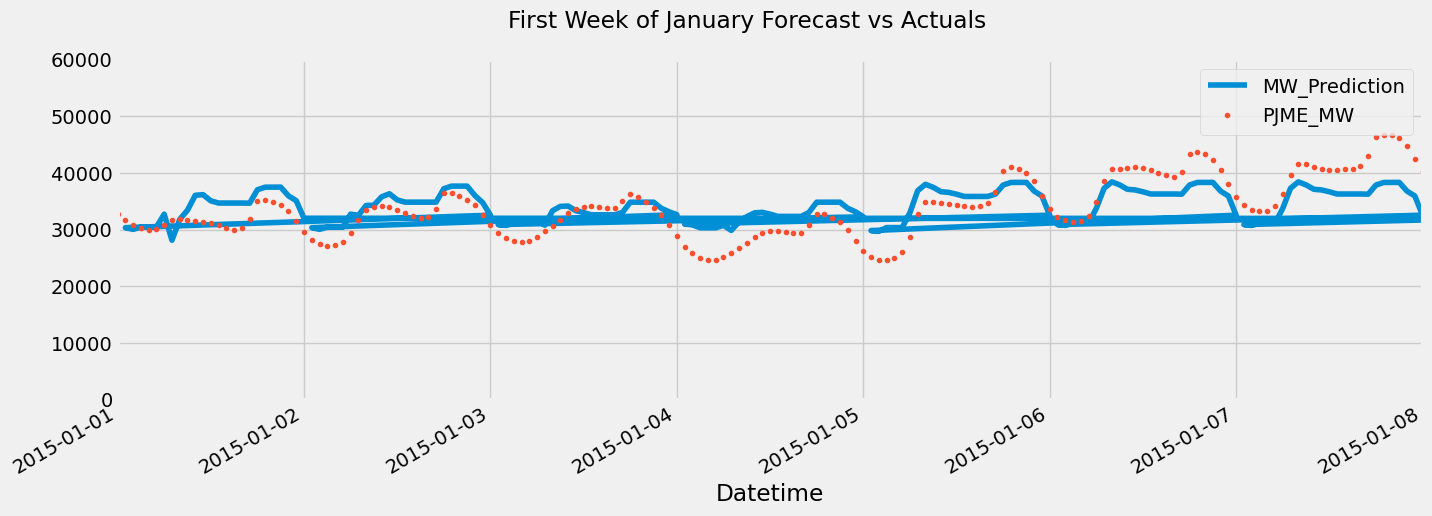

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

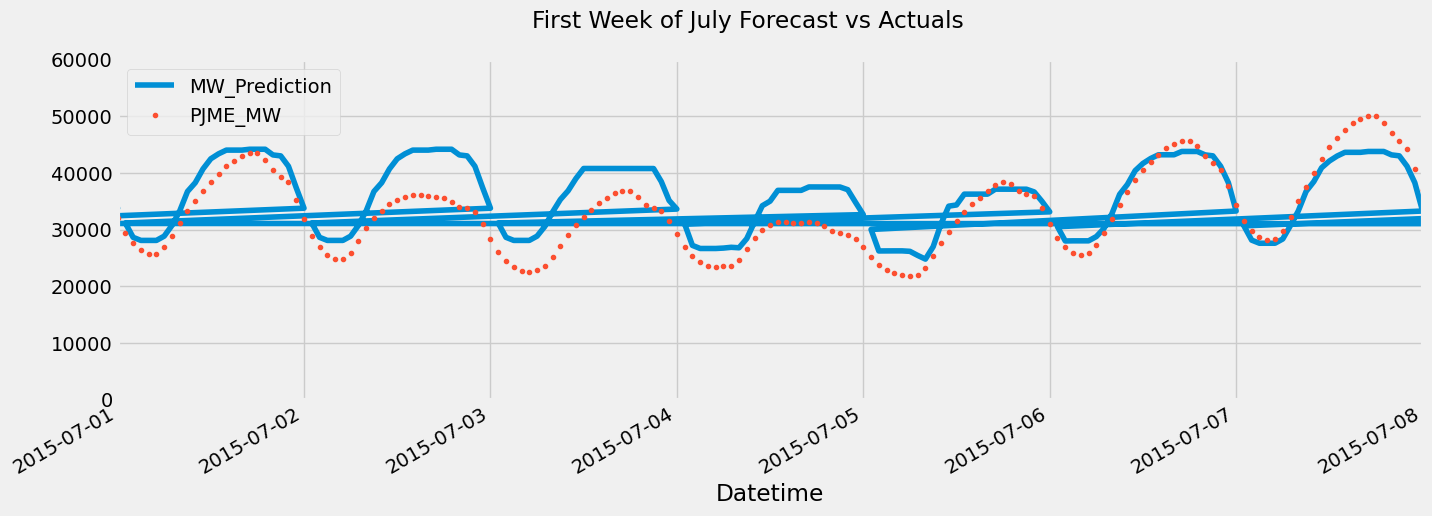

In [18]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics On Test Set
Our RMSE error is 13780445  
Our MAE error is 2848.89  
Our MAPE error is 8.9%

In [19]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

14324853.401441628

In [20]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2956.500888936214

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

9.412178325772043

# Look at Worst and Best Predicted Days

In [23]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [24]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   37188.906250 -8788.947266  8788.947266
2015 12    25          24466.083333   32228.029297 -7761.945150  7761.945150
2017 5     29          24528.416667   32194.498047 -7666.081055  7666.081055
     2     24          26445.083333   34001.175781 -7556.094564  7556.094564
     6     8           26943.791667   34342.902344 -7399.108317  7399.108317
     2     20          27070.583333   34393.093750 -7322.511719  7322.511719
           25          24344.458333   31644.669922 -7300.211100  7300.211100
           19          24555.500000   31765.490234 -7209.988770  7209.988770
2018 2     21          27572.500000   34711.347656 -7138.845785  7138.845785
2016 6     9           27318.083333   34436.015625 -7117.932780  7117.932780

Notice anything about the over forecasted days? 
- #1 worst day - July 4th, 2016 - is a holiday. 
- #3 worst day - December 25, 2015 - Christmas
- #5 worst day - July 4th, 2016 - is a holiday.   
Looks like our model may benefit from adding a holiday indicator.

In [25]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31917.646484  13268.187174  13268.187174
           14          44427.333333   31467.203125  12960.131510  12960.131510
     9     10          40996.166667   29433.314453  11562.851562  11562.851562
     8     12          45724.708333   34724.277344  11000.430176  11000.430176
     9     9           43836.958333   33054.921875  10782.036214  10782.036214
2018 1     6           43565.750000   32799.394531  10766.356934  10766.356934
2015 2     20          44694.041667   33931.441406  10762.597900  10762.597900
2018 1     7           42159.708333   32357.298828   9802.408610   9802.408610
2016 7     23          42088.458333   32558.552734   9529.906657   9529.906657
2015 2     16          43949.500000   34428.207031   9521.292806   9521.292806

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may

In [26]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 10    27          28611.166667   28890.281250 -279.114176  427.351969
     1     12          35334.041667   35509.730469 -175.691325  437.421956
     12    30          32213.458333   32354.853516 -141.396566  446.747477
     4     4           28944.125000   29146.515625 -202.390381  494.045654
2017 10    24          28657.416667   28890.281250 -232.864176  517.345622
2015 10    28          28500.958333   28890.281250 -389.322510  525.025960
2017 12    8           32779.291667   33106.683594 -327.392985  555.826416
2015 12    19          30499.833333   30916.726562 -416.893229  561.989909
     1     16          35331.875000   35479.699219 -147.824870  580.482096
2016 3     20          27989.416667   27598.916016  390.499756  586.580485

# Plotting some best/worst predicted days

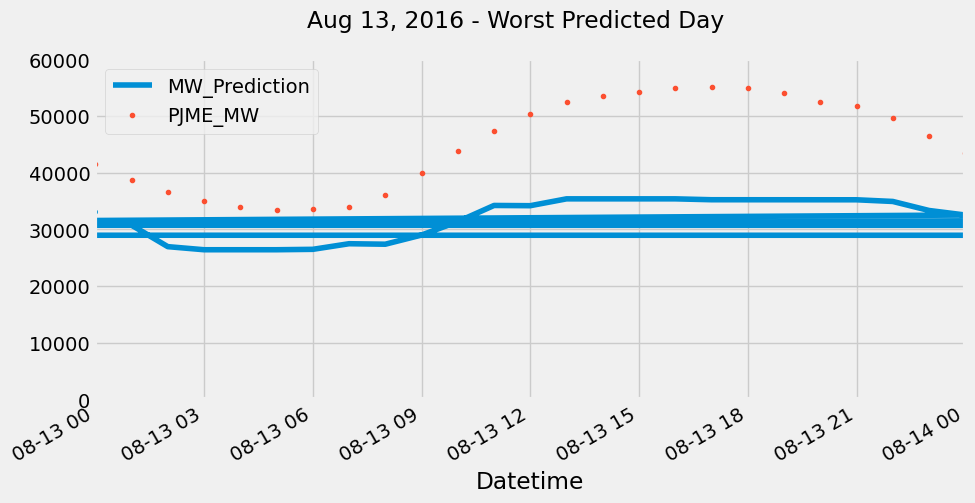

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

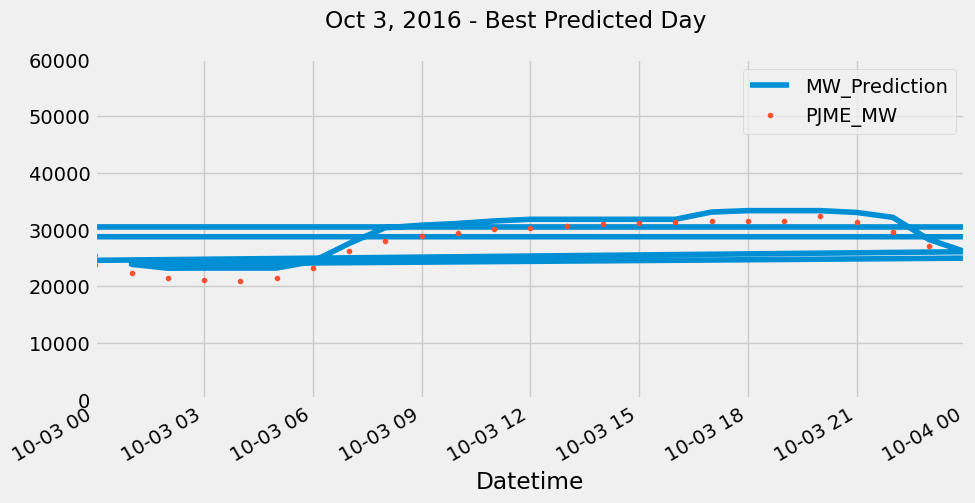

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

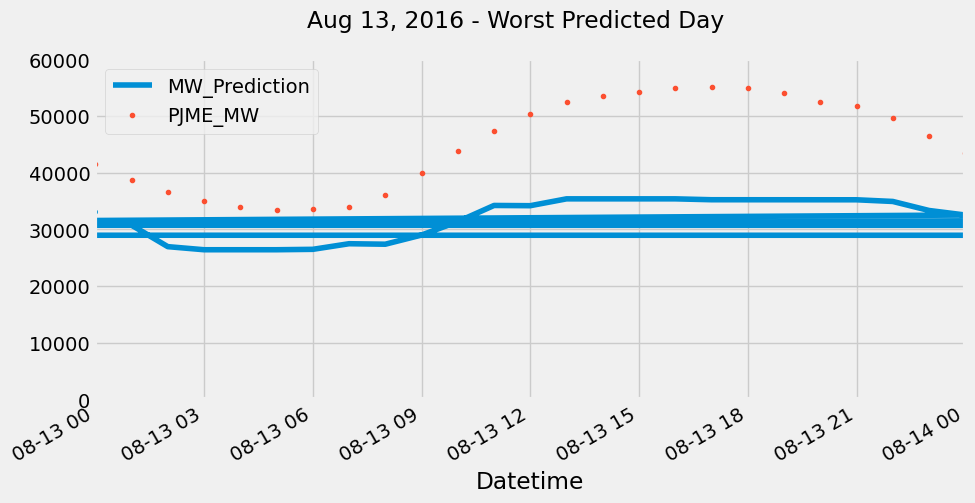

In [29]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

# Up next?
- Add Lag variables
- Add holiday indicators.
- Add weather data source.